#  Introdução à Ciência de Dados - SCC0275
## Análise de séries temporais - previsão de preço de combustíveis no Brasil
### Alunos:
   - Josué Grâce Kabongo Kalala - 9770382
   - Matheus Saldanha Junqueira - 9763234

### Professor:
    Rodrigo Fernandes de Mello

Esse projeto tem como objetivo criar um modelo de previsão de preços em R$/l de combustíveis os quais são: **ETANOL HIDRATADO**, **GASOLINA COMUM**, **GLP**, **GNV**, **ÓLEO DIESEL** e **ÓLEO DIESEL S10**, para qualquer estado do Brasil.

Para isso, iremos usar o conjuto de dados coletado pela agência nacional de petróleo gás e biocombustíveis (ANP) e disponibilzado na plataforma do [Kaggle](https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil). 

# Parte I: Uma análise explorativa dos dados

In [12]:
dataframe = read.table("2004-2019.tsv",sep="\t",header=T)
head(dataframe,3)

X,DATA.INICIAL,DATA.FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO.DE.POSTOS.PESQUISADOS,UNIDADE.DE.MEDIDA,PREÇO.MÉDIO.REVENDA,DESVIO.PADRÃO.REVENDA,⋯,PREÇO.MÁXIMO.REVENDA,MARGEM.MÉDIA.REVENDA,COEF.DE.VARIAÇÃO.REVENDA,PREÇO.MÉDIO.DISTRIBUIÇÃO,DESVIO.PADRÃO.DISTRIBUIÇÃO,PREÇO.MÍNIMO.DISTRIBUIÇÃO,PREÇO.MÁXIMO.DISTRIBUIÇÃO,COEF.DE.VARIAÇÃO.DISTRIBUIÇÃO,MÊS,ANO
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,⋯,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,⋯,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,⋯,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004


O conjunto de dados possui 106822 instâncias e 21 attributos.
Os attributos que são mais relevantes para nossa análise são o **Preço Médio de revenda**, **Desvio Padrao de revenda**, **Preço Mínimo de revenda**, **Preço Máximo de revenda** , a **Região**, o **Estado**, o **Produto**, a **Data Inicial** e a **Data Final**, o **Mês** e o **Ano**.

Portanto iremos remover as outras colunas.

In [13]:
#Removing unecessary columns
dataframe = subset(dataframe,select=-c(1,7,13,14,15,16,17,18,19))
#Renaming the columns names
colnames(dataframe) = c("Start_Date","End_Date","Region","State","Product","Unit","Avg_Market_Value","Std_Dev","Min_Price","Max_Price","Month","Year")
#Converting the products names type to be characters
dataframe$Product = as.character(dataframe$Product,stringsAsFactors=F)
#Converting the dates to be in date formats
dataframe$Start_Date = as.Date(dataframe$Start_Date,format='%Y-%m-%d')
dataframe$End_Date = as.Date(dataframe$End_Date,format='%Y-%m-%d')
#Change some products names 
dataframe[which(dataframe$Product == "ÓLEO DIESEL"),5] = "OLEO DIESEL"
dataframe[which(dataframe$Product == "ÓLEO DIESEL S10"),5] = "OLEO DIESEL S10"
head(dataframe,3)

Start_Date,End_Date,Region,State,Product,Unit,Avg_Market_Value,Std_Dev,Min_Price,Max_Price,Month,Year
<date>,<date>,<fct>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,R$/l,1.288,0.016,1.19,1.350,5,2004
2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,R$/l,1.162,0.114,0.89,1.449,5,2004
2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,R$/l,1.389,0.097,1.18,1.760,5,2004


### Descobrindo algumas características improtantes do conjunto de dados:
- Quantos e quais estados estão representados ?
- Quantas e quais regiões estão representadas ?
- Quais produtos o conjuto de dados possui ?

Número de estados:  27 
 [1] DISTRITO FEDERAL    GOIAS               MATO GROSSO        
 [4] MATO GROSSO DO SUL  ALAGOAS             BAHIA              
 [7] CEARA               MARANHAO            PARAIBA            
[10] PERNAMBUCO          PIAUI               RIO GRANDE DO NORTE
[13] SERGIPE             ACRE                AMAPA              
[16] AMAZONAS            PARA                RONDONIA           
[19] RORAIMA             TOCANTINS           ESPIRITO SANTO     
[22] MINAS GERAIS        RIO DE JANEIRO      SAO PAULO          
[25] PARANA              RIO GRANDE DO SUL   SANTA CATARINA     
27 Levels: ACRE ALAGOAS AMAPA AMAZONAS BAHIA CEARA ... TOCANTINS

Número de regiões:  5 
[1] CENTRO OESTE NORDESTE     NORTE        SUDESTE      SUL         
Levels: CENTRO OESTE NORDESTE NORTE SUDESTE SUL

Quantos produtos:  6 
[1] "ETANOL HIDRATADO" "GASOLINA COMUM"   "GLP"              "GNV"             
[5] "OLEO DIESEL"      "OLEO DIESEL S10" 


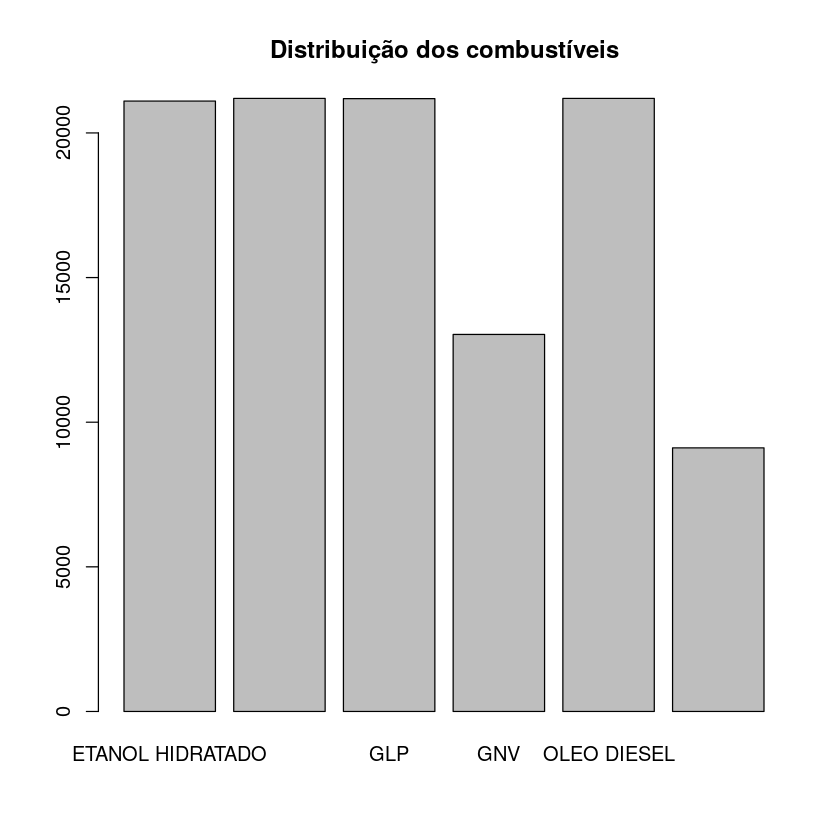

In [36]:
library(ggplot2)
cat("Número de estados: ", length(unique(dataframe$State)),"\n")
print(unique(dataframe$State))
cat("\nNúmero de regiões: ", length(unique(dataframe$Region)),"\n")
print(unique(dataframe$Region))
cat("\nQuantos produtos: ", length(unique(dataframe$Product)),"\n")
print(unique(dataframe$Product))
barplot(table(dataframe$Product), main="Distribuição dos combustíveis")

### Vamos agora dar uma olhada nas séries temporais de cada produto

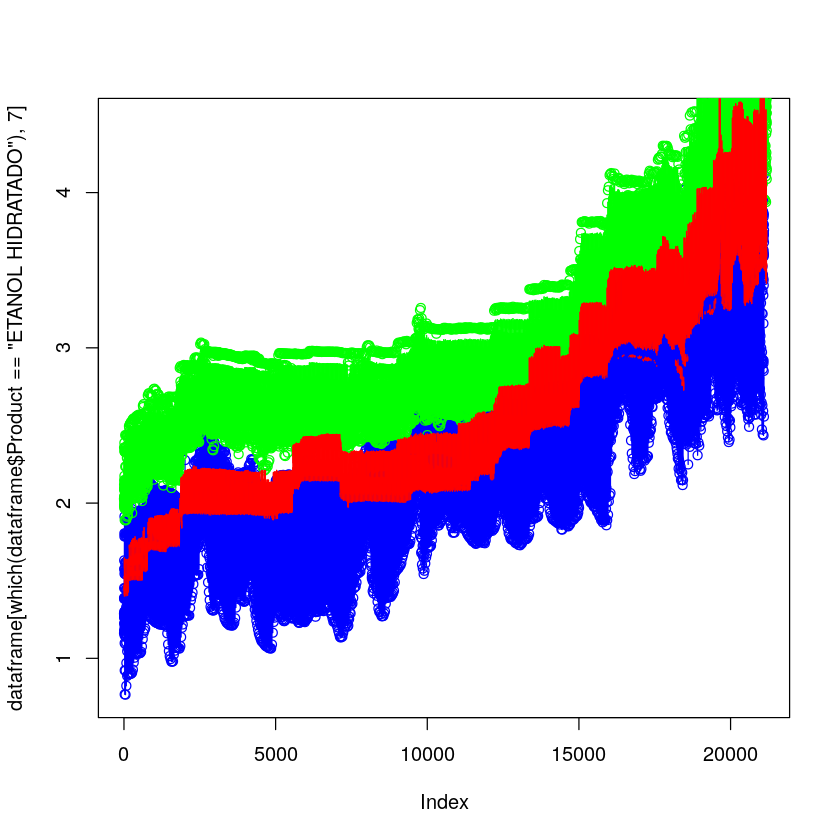

In [56]:
products = c("GASOLINA COMUM","GLP","OLEO DIESEL")
colors = c("green","yellow","red")
types = c("b","o","c")
plot(dataframe[which(dataframe$Product == "ETANOL HIDRATADO"),7],type="o",col="blue")
for (i in 1:3) {
    lines(dataframe[which(dataframe$Product == products[i]),7],type=types[i],col=colors[i])
    #lines(dataframe[which(dataframe$Product == products[i]),7],col=colors[i]])
}